In [1]:
pip install praw tensorflow nltk imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
import praw
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Attention, Concatenate, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [43]:
import praw
import pandas as pd

# Reddit API credentials
CLIENT_ID = 'WUCFk8_roqby_-f33pf4Sg'
CLIENT_SECRET = 'qgX6GKX3bxiK6RjYHQnevIvWBIj-Vw'
USER_AGENT = 'python:FakeNewsDetector:v1.0 (by /u/Kitchen_Arm_7570)'

# Initialize Reddit instance
reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=USER_AGENT)

# Fetch posts from Reddit and include both title (headline) and URL
def fetch_reddit_data(subreddit_name, limit=500):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.hot(limit=limit):
        posts.append({'title': post.title, 'url': post.url})
    return posts

# Collect data from multiple subreddits
real_news = fetch_reddit_data('news', limit=500)
fake_news = fetch_reddit_data('fakenews', limit=500)

# Combine into a DataFrame with title, URL, and label
real_news_data = pd.DataFrame(real_news)
real_news_data['label'] = 1  # 1 for real news

fake_news_data = pd.DataFrame(fake_news)
fake_news_data['label'] = 0  # 0 for fake news

# Combine real and fake news data
data = pd.concat([real_news_data, fake_news_data], ignore_index=True)

# Display the DataFrame with headlines, URLs, and labels
print(data.head())


                                               title  \
0  Israel orders closure of Dublin embassy, blami...   
1  Russian tanker splits in storm, spilling oil i...   
2  Nancy Pelosi has hip replacement surgery after...   
3  Warren, Hawley introduce bill requiring insure...   
4  Texas man gets 100 years in prison for shootin...   

                                                 url  label  
0  https://news.sky.com/story/israel-orders-closu...      1  
1  https://www.reuters.com/world/europe/russian-c...      1  
2  https://www.cbsnews.com/news/nancy-pelosi-hosp...      1  
3  https://www.fiercehealthcare.com/payers/warren...      1  
4  https://apnews.com/article/killing-shooting-ra...      1  


In [69]:
data.head(10)

,title,url,label,cleaned_text
0,"Israel orders closure of Dublin embassy, blami...",https://news.sky.com/story/israel-orders-closu...,1,israel orders closure dublin embassy blaming e...
1,"Russian tanker splits in storm, spilling oil i...",https://www.reuters.com/world/europe/russian-c...,1,russian tanker splits storm spilling oil kerch...
2,Nancy Pelosi has hip replacement surgery after...,https://www.cbsnews.com/news/nancy-pelosi-hosp...,1,nancy pelosi hip replacement surgery injury eu...
3,"Warren, Hawley introduce bill requiring insure...",https://www.fiercehealthcare.com/payers/warren...,1,warren hawley introduce bill requiring insurer...
4,Texas man gets 100 years in prison for shootin...,https://apnews.com/article/killing-shooting-ra...,1,texas man gets years prison shootings killed w...
5,US jury finds Vegas police fabricated evidence...,https://www.cnn.com/2024/12/14/us/kirstin-loba...,1,us jury finds vegas police fabricated evidence...
6,Luigi Mangione retains high-powered New York a...,https://www.cnn.com/2024/12/13/us/luigi-mangio...,1,luigi mangione retains highpowered new york at...
7,ABC agrees to give $15 million to Donald Trump...,https://apnews.com/article/abc-trump-lawsuit-d...,1,abc agrees give million donald trumps presiden...
8,"Bob Fernandez, 100-year-old Pearl Harbor survi...",https://www.cnn.com/2024/12/14/us/bob-fernande...,1,bob fernandez yearold pearl harbor survivor di...
9,Drone sighting temporarily shuts down runways ...,https://abcnews.go.com/US/drone-sighting-tempo...,1,drone sighting temporarily shuts runways new y...


In [73]:
data.tail(10)

,title,url,label,cleaned_text
659,PolitiFact - Lie of the Year: Coronavirus down...,https://www.politifact.com/article/2020/dec/16...,0,politifact lie year coronavirus downplay denial
660,Here is this exclusive extension for your brow...,https://www.makeitmagazine.net/2020/12/here-is...,0,exclusive extension browser help verify combat...
661,Will you be taking the Bill Gates Vaccine?,/r/NoirVeracity/comments/kc8rvn/are_you_taking...,0,taking bill gates vaccine
662,"Clintons Host Trumps, Obamas: Mole Children on...",https://www.reddit.com/r/fakenews/comments/kbc...,0,clintons host trumps obamas mole children table
663,What household item is most like Donald Trump?,https://www.reddit.com/r/fakenews/comments/kbc...,0,household item like donald trump
664,Jake Fired by State Farm,https://theliarslair.com/jake-fired-by-state-f...,0,jake fired state farm
665,Facebook’s ‘independent’ fact-checking certifi...,https://newest-websites.com/facebooks-independ...,0,facebooks independent factchecking certifier e...
667,Washington Football Team Player Slipped a Pitt...,https://connorcostan.medium.com/washington-foo...,0,washington football team player slipped pittsb...
668,Misinformation and Disinformation - Security E...,http://securityexplained.fm/1245467/6764674-mi...,0,misinformation disinformation security explain...
669,The Neverlands Discover That Weed Is An Extrem...,https://www.reddit.com/r/fakenews/comments/k9w...,0,neverlands discover weed extremely effective c...


In [47]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords

# Download NLTK stopwords (if not already downloaded)
nltk.download('stopwords')

# Data Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs (regex pattern for URLs)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove non-alphabetic characters (keeping only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply cleaning function to the 'text' column
data['cleaned_text'] = data['title'].apply(clean_text)

# Remove any rows with missing values (if any)
data = data.dropna(subset=['cleaned_text'])

# Remove duplicate rows
data = data.drop_duplicates(subset=['cleaned_text'])

# Display the cleaned data
print(data.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT0001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               title  \
0  Israel orders closure of Dublin embassy, blami...   
1  Russian tanker splits in storm, spilling oil i...   
2  Nancy Pelosi has hip replacement surgery after...   
3  Warren, Hawley introduce bill requiring insure...   
4  Texas man gets 100 years in prison for shootin...   

                                                 url  label  \
0  https://news.sky.com/story/israel-orders-closu...      1   
1  https://www.reuters.com/world/europe/russian-c...      1   
2  https://www.cbsnews.com/news/nancy-pelosi-hosp...      1   
3  https://www.fiercehealthcare.com/payers/warren...      1   
4  https://apnews.com/article/killing-shooting-ra...      1   

                                        cleaned_text  
0  israel orders closure dublin embassy blaming e...  
1  russian tanker splits storm spilling oil kerch...  
2  nancy pelosi hip replacement surgery injury eu...  
3  warren hawley introduce bill requiring insurer...  
4  texas 

In [51]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# Pad sequences
max_length = 50
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = data['label'].values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)


In [53]:
# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        word, *vector = line.split()
        embedding_index[word] = np.array(vector, dtype='float32')

# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector


In [55]:
# LSTM branch
input_lstm = Input(shape=(max_length,))
embedding = Embedding(input_dim=len(word_index) + 1,
                      output_dim=embedding_dim,
                      embeddings_initializer='uniform',
                      input_length=max_length,
                      trainable=False)(input_lstm)

lstm = LSTM(256, return_sequences=True)(embedding)
attention = Attention()([lstm, lstm])
flatten = Flatten()(attention)

# MLP branch
input_mlp = Input(shape=(max_length,))
mlp = Dense(256, activation='relu')(input_mlp)
mlp = Dropout(0.3)(mlp)

# Combine both branches
combined = Concatenate()([flatten, mlp])
output = Dense(128, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(output)

# Compile the model
model = Model(inputs=[input_lstm, input_mlp], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


C:\Users\KIIT0001\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 100)   │    283,800 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50, 256)   │    365,568 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 50, 256)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     13,056 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 13056)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │  1,671,296 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,333,849 (8.90 MB)

 Trainable params: 2,050,049 (7.82 MB)

 Non-trainable params: 283,800 (1.08 MB)

None


In [57]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    [X_train, X_train], y_train,
    epochs=50,
    batch_size=64,
    validation_data=([X_test, X_test], y_test),
    callbacks=callbacks
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.5983 - loss: 21.1181 - val_accuracy: 0.6489 - val_loss: 10.5338 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.7763 - loss: 4.9265 - val_accuracy: 0.6947 - val_loss: 3.0396 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.7083 - loss: 2.3176 - val_accuracy: 0.7328 - val_loss: 1.4353 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.7355 - loss: 1.1641 - val_accuracy: 0.6412 - val_loss: 1.8971 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - accuracy: 0.8245 - loss: 0.6999 - val_accuracy: 0.6641 - val_loss: 1.4987 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.8278 - loss: 0.6105 - val_accuracy: 0.6947 - val_loss: 0.7874 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - accuracy: 0.8127 - loss: 0.5499 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9082 - loss: 0.2041
Test Accuracy: 91.60%


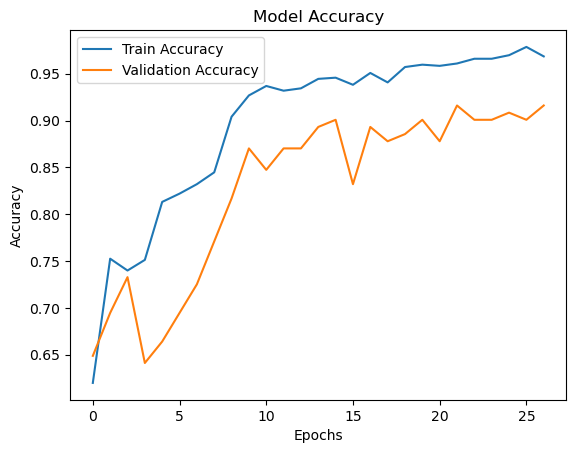

In [59]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test, X_test], y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [71]:
def predict_news(news_text):
    processed_text = preprocess_text(news_text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    prediction = model.predict([padded_sequence, padded_sequence])
    return "Real News" if prediction[0][0] > 0.5 else "Fake News"

# Test with user input
user_input = input("Enter a news headline: ")
print("Prediction:", predict_news(user_input))


Enter a news headline:  ABC agrees to give $15 million to Donald Trump's presidential library to settle defamation lawsuit


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: Real News
